In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Utils import *
import numba as nb
from numba import njit

import torch
from sbi.analysis import pairplot
from sbi.inference import SNPE, simulate_for_sbi
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from sbi.inference import SNPE, SNLE, prepare_for_sbi, simulate_for_sbi 
from sbi import analysis as analysis

### 1. Load simulated data

In [6]:
# Load the simulated data
data = np.load('saved/SBI_data_plasticity_10thousand.npz')
print("Data loaded")
data['theta'].shape

Data loaded


(10000, 8)

In [9]:
# check for nan values in theta
np.sum(data['theta'] == np.nan)

0

In [11]:
# If the data is loaded but not simulated
# Convert from numpy to torch
theta = torch.from_numpy(data['theta'])
x = torch.from_numpy(data['x'])

In [12]:
# Range of values of theta
u = theta.unique()
u.max(), u.min()

(tensor(1.0000), tensor(2.2650e-06))

### 2. Filter the data of required conditions

In [6]:
# Filter stability and or balance
# x - S, B, D, A, mu, sigma, r_squared
# FILTERED THE DATA FOR THE DESIRED VALUES OF LOSS

# Filter second on S
#idx = x[:,0] < 0.1

#theta_filtered = theta[idx]

# Only select the corresponding value of sigma
#x_filtered = x[idx,5][:,None]
#x_filtered.size()

torch.Size([761, 1])

### 3. Inference

In [7]:
# Define the prior 
# number of parameters
num_dim = 8 # eta_e, eta_i

# Define priors 
prior = BoxUniform(low=0 * torch.ones(num_dim), high=1 * torch.ones(num_dim))


#estimator = posterior_nn(model='nsf')
# instantiate the inference object
inference = SNPE(prior=prior)
# compute the inference
# ACHTUNG! need to change theta_filtered and x_filtered
inference = inference.append_simulations(theta_filtered, x_filtered)

In [8]:
inference

In [9]:
# train the neural density estimator
density_estimator = inference.train()

 Neural network successfully converged after 87 epochs.

In [10]:
# Generate the posterior
posterior = inference.build_posterior(density_estimator)

In [11]:
posterior

DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>

### 4. Study the posterior distribution

In [17]:
# Vogels paper sample from posterior
#How many samples to generate
post_num_samples = 10

#What should their metric values be (here the only metric is the rate of excitation, and we want it to be between 5 and 10)
default_x = torch.tensor([[np.random.random()*5+5] for i in range(post_num_samples)])
default_x

tensor([[5.3923],
        [5.8462],
        [7.1847],
        [6.4765],
        [6.9613],
        [6.4643],
        [5.0351],
        [9.1990],
        [5.0306],
        [5.9905]])

In [12]:
# For the observation we are taking the standar deviation of the tunning curve
# looking at the parameters that produce specific width of tunning curve
observation = observation = torch.zeros(1) + 0.01


In [18]:
# Sample from the posterior conditioned on the obsrvation 
posterior_samples = posterior.sample((10000,), x=observation)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [22]:
posterior_samples

tensor([[0.5350, 0.1978, 0.3773,  ..., 0.8101, 0.6523, 0.3221],
        [0.8177, 0.7587, 0.1889,  ..., 0.2852, 0.4690, 0.5113],
        [0.9671, 0.3444, 0.1709,  ..., 0.3100, 0.5057, 0.9069],
        ...,
        [0.1810, 0.3642, 0.0808,  ..., 0.5149, 0.5852, 0.5046],
        [0.6685, 0.1639, 0.8346,  ..., 0.5241, 0.3833, 0.8924],
        [0.6441, 0.5469, 0.7052,  ..., 0.1063, 0.3171, 0.6585]])

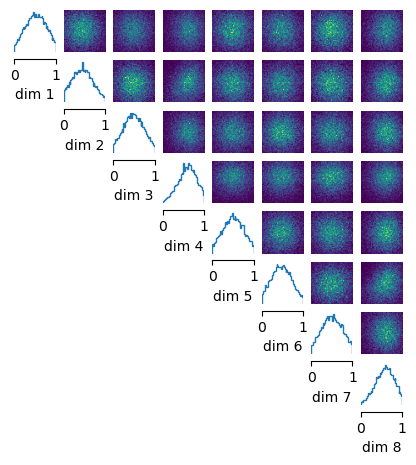

In [14]:
# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1]], figsize=(5, 5)
)